# Tests

## 01. Preliminary tests

### 01.1. Create a scale of notes and compute its CQT spectrogram

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


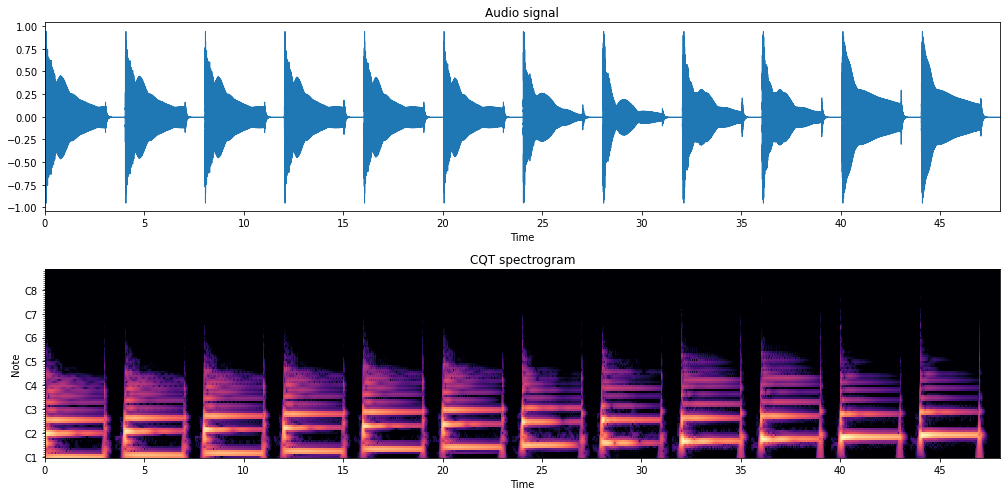

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define the parameters for the notes to concatenate
folder_path = r'nsynth\nsynth-train\audio'
instrument_names = ['bass_acoustic_000']
note_number = 24
note_numbers = np.arange(note_number, note_number+12)
velocity_number = 75
sampling_frequency = 16000

# Initialize the audio signal
audio_signal = np.empty(0)

# Loop over the instrument names and note numbers to concatenate the notes
for instrument_name in instrument_names:
    for note_number in note_numbers:
    
        # Get the path to the file
        file_name = f'{instrument_name}-{note_number:03d}-{velocity_number:03d}.wav'
        file_path = os.path.join(folder_path, file_name)
        
        # Load the current audio signal and concatenate them
        audio_signal1, _ = librosa.load(file_path, sr=sampling_frequency, mono=True)
        audio_signal = np.concatenate((audio_signal, audio_signal1))
        
        
# Comptute the CQT spectrogram of the signal
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
minimum_frequency = 32.70
maximum_frequency = sampling_frequency/2
octave_resolution = 12
number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
audio_cqt = librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                        n_bins=number_frequencies, bins_per_octave=octave_resolution)
cqt_spectrogram = np.abs(audio_cqt)

# Display the audio signal and the CQT spectrogram
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
librosa.display.waveplot(audio_signal, sr=sampling_frequency)
plt.title('Audio signal')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note', bins_per_octave=octave_resolution)
plt.title('CQT spectrogram')
plt.tight_layout()
plt.show()

### 01.2. Decompose the CQT spectrogram into a CQT envelope and a CQT pitch, with and without refinement

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since 

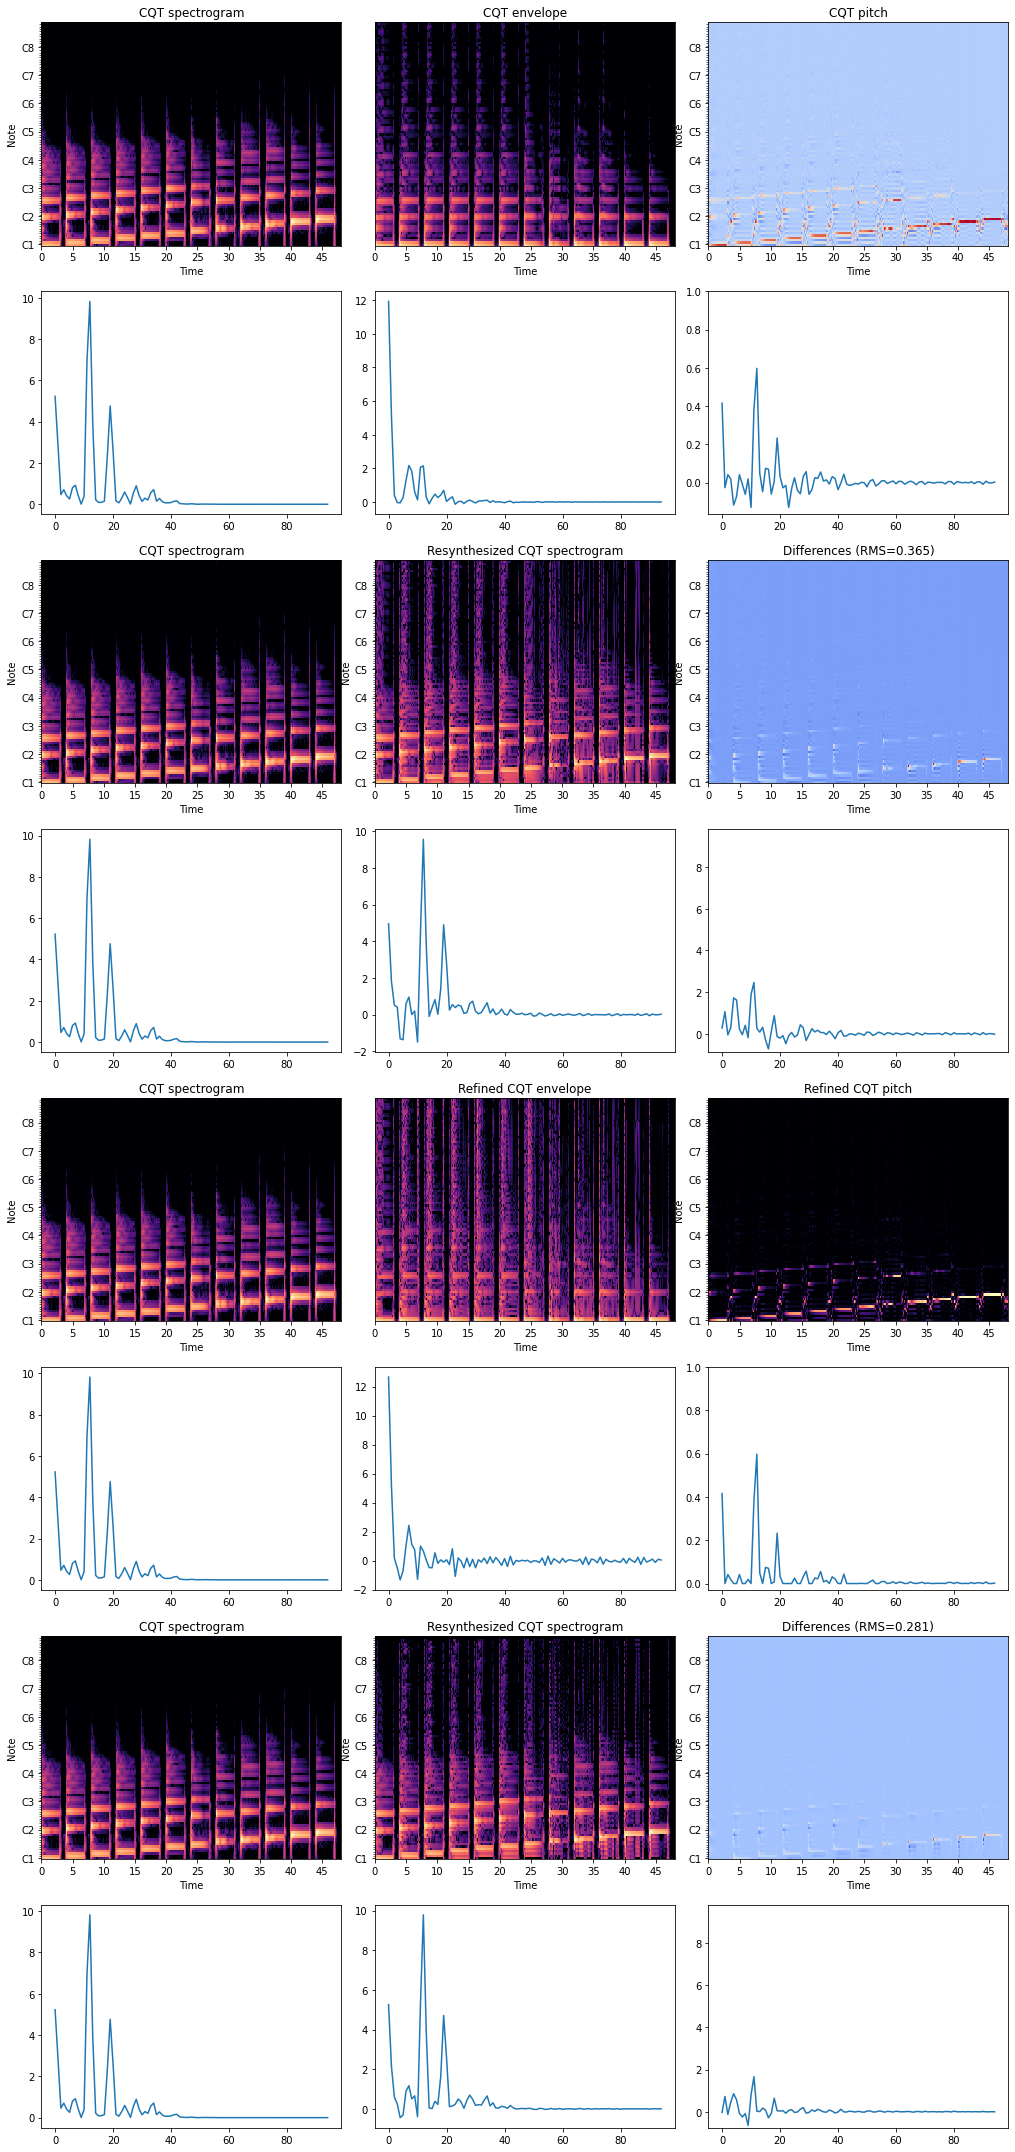

In [12]:
# Derive the CQT envelope and the CQT pitch
ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
absftcqt_spectrogram = abs(ftcqt_spectrogram)
cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/absftcqt_spectrogram, axis=0)[0:number_frequencies, :])

# Resynthesize the CQT spectrogram by convolving the CQT envelope and CQT pitch
number_times = np.shape(cqt_spectrogram)[1]
cqt_spectrogram2 = np.zeros((number_frequencies, number_times))
for i in range(number_times):
    cqt_spectrogram2[:, i] = np.convolve(cqt_envelope[:, i], cqt_pitch[:, i])[0:number_frequencies]

# Display the CQT spectrogram, the CQT envelope and CQT pitch, the resynthesized CQT spectrogram, and the differences
j = 10
plt.figure(figsize=(14, 30))
plt.subplot(8, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT spectrogram')
plt.subplot(8, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_envelope, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time')
plt.title('CQT envelope')
plt.subplot(8, 3, 3)
librosa.display.specshow(cqt_pitch, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                         bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
plt.title('CQT pitch')
plt.subplot(8, 3, 4)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 5)
plt.plot(cqt_envelope[:, j])
plt.subplot(8, 3, 6)
plt.plot(cqt_pitch[:, j])
plt.ylim(top=1)

plt.subplot(8, 3, 7)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT spectrogram')
plt.subplot(8, 3, 8)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('Resynthesized CQT spectrogram')
plt.subplot(8, 3, 9)
librosa.display.specshow(cqt_spectrogram-cqt_spectrogram2, sr=sampling_frequency, hop_length=step_length, \
                         fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
rms_value = np.round(np.sqrt(np.mean(np.power(cqt_spectrogram-cqt_spectrogram2, 2))), 3)
plt.title(f'Differences (RMS={rms_value})')
plt.subplot(8, 3, 10)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 11)
plt.plot(cqt_spectrogram2[:, j])
plt.subplot(8, 3, 12)
plt.plot(cqt_spectrogram[:, j]-cqt_spectrogram2[:, j])
plt.ylim(top=max(cqt_spectrogram[:, j]))


# Refine the CQT pitch, and then the CQT envelope
cqt_pitch2 = np.copy(cqt_pitch)
cqt_pitch2[cqt_pitch2 < 0] = 0
cqt_envelope2 = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch2, 2*number_frequencies-1, axis=0)+1e-7), \
                                    axis=0)[0:number_frequencies, :])

# Resynthesize the CQT spectrogram by convolving the refined CQT envelope and CQT pitch
cqt_spectrogram2 = np.zeros((number_frequencies, number_times))
for i in range(number_times):
    cqt_spectrogram2[:, i] = np.convolve(cqt_envelope2[:, i], cqt_pitch2[:, i])[0:number_frequencies]

# Display everything again with the refined versions
plt.subplot(8, 3, 13)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT spectrogram')
plt.subplot(8, 3, 14)
librosa.display.specshow(librosa.amplitude_to_db(cqt_envelope2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time')
plt.title('Refined CQT envelope')
plt.subplot(8, 3, 15)
librosa.display.specshow(cqt_pitch2, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                         bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
plt.title('Refined CQT pitch')
plt.subplot(8, 3, 16)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 17)
plt.plot(cqt_envelope2[:, j])
plt.subplot(8, 3, 18)
plt.plot(cqt_pitch2[:, j])
plt.ylim(top=1)
plt.subplot(8, 3, 19)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT spectrogram')
plt.subplot(8, 3, 20)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('Resynthesized CQT spectrogram')
plt.subplot(8, 3, 21)
librosa.display.specshow(cqt_spectrogram-cqt_spectrogram2, sr=sampling_frequency, hop_length=step_length, \
                         fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
rms_value = np.round(np.sqrt(np.mean(np.power(cqt_spectrogram-cqt_spectrogram2, 2))), 3)
plt.title(f'Differences (RMS={rmse_value})')
plt.subplot(8, 3, 22)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 23)
plt.plot(cqt_spectrogram2[:, j])
plt.subplot(8, 3, 24)
plt.plot(cqt_spectrogram[:, j]-cqt_spectrogram2[:, j])
plt.ylim(top=max(cqt_spectrogram[:, j]))
plt.tight_layout()
plt.show()

# # Resynthesize the signal
# audio_signal2 = librosa.icqt(cqt_spectrogram2*audio_cqt/cqt_spectrogram, sr=sampling_frequency, \
#                              hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution)
# audio_signal2 = np.max(abs(audio_signal))*audio_signal2/np.max(abs(audio_signal2))
# audio_signal2 = np.pad(audio_signal2, (0, len(audio_signal)-len(audio_signal2)), 'constant', constant_values=0)

### 01.3. Extract the CQT-SECs from the CQT envelope and compare them to the MFCCs

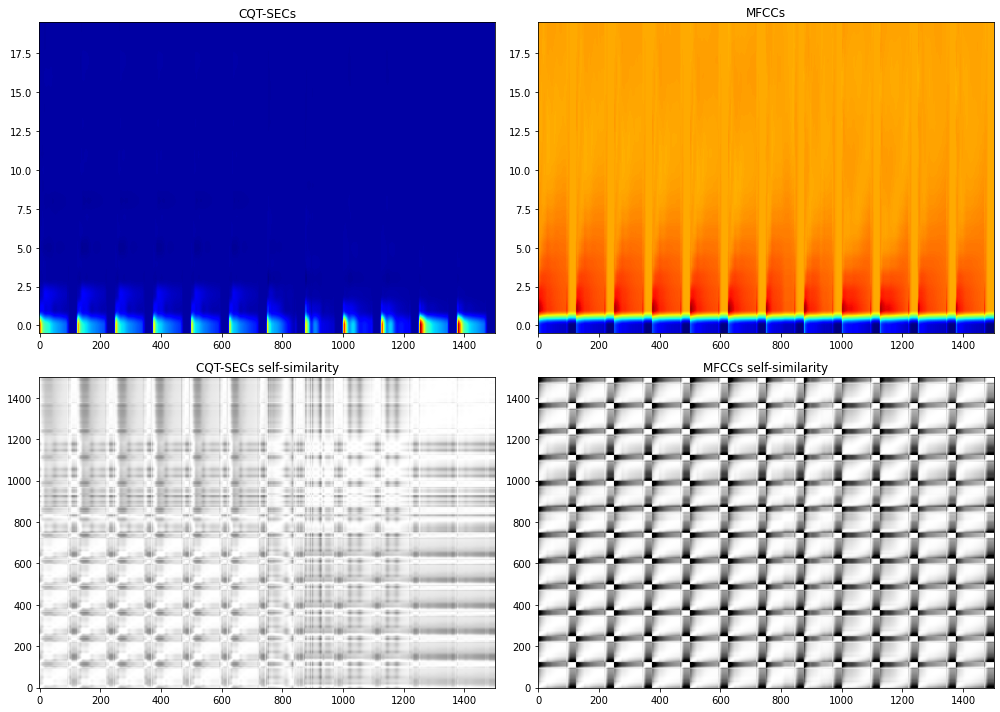

In [16]:
# Extract the CQT-SECs from the CQT envelope
number_coefficients = 20
coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
cqt_sec = cqt_envelope[coefficient_indices, :]

# Compute the MFCCs using librosa
window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
step_length = int(window_length/2)
audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)

# Compute the self-similarity matrices for the CQT-SECs and the MFCCs
normalized_feature = cqt_sec/(np.sqrt(np.sum(np.power(cqt_sec, 2), axis=0))+1e-16)
similarity_matrix1 = np.matmul(normalized_feature.T, normalized_feature)
normalized_feature = audio_mfcc/(np.sqrt(np.sum(np.power(audio_mfcc, 2), axis=0))+1e-16)
similarity_matrix2 = np.matmul(normalized_feature.T, normalized_feature)

# Plot the features and their self-similarity matrices
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.imshow(cqt_sec, aspect='auto', cmap='jet', origin='lower')
plt.title('CQT-SECs')
plt.subplot(2, 2, 2)
plt.imshow(audio_mfcc, cmap='jet', aspect='auto', origin='lower')
plt.title('MFCCs')
plt.subplot(2, 2, 3)
plt.imshow(similarity_matrix1, cmap='gray', aspect='auto', origin='lower', vmin=0.9, vmax=1)
plt.title('CQT-SECs self-similarity')
plt.subplot(2, 2, 4)
plt.imshow(similarity_matrix2, cmap='gray', aspect='auto', origin='lower', vmin=0.9, vmax=1)
plt.title('MFCCs self-similarity')
plt.tight_layout()
plt.show()

## 02. Test on a Small Dataset

### 02.1. Create a small dataset from the NSynth dataset (DONE)

In [2]:
import os
from shutil import copyfile

# Define the folders
folder_path = r'nsynth\nsynth-train\audio'
folder_path2 = r'nsynth11'

# Define the instrument names, numbers, and MIDIs
instrument_list = [{'name':'bass_acoustic', 'number': '000', 'midi': 24}, \
                   {'name':'brass_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'flute_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'guitar_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'keyboard_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'mallet_acoustic', 'number': '000', 'midi': 72}, \
                   {'name':'organ_electronic', 'number': '000', 'midi': 60}, \
                   {'name':'reed_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'string_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'synth_lead_synthetic', 'number': '000', 'midi': 60}, \
                   {'name':'vocal_acoustic', 'number': '002', 'midi': 60}]

# Loop over the list and notes to create the dataset
os.mkdir(folder_path2)
number_semitones = 12
for i in instrument_list:
    for j in range(i['midi'], i['midi']+number_semitones):
        file_name = f"{i['name']}_{i['number']}-{j:03d}-075.wav"
        file_path = os.path.join(folder_path, file_name)
        file_path2 = os.path.join(folder_path2, file_name)
        copyfile(file_path, file_path2)

### 02.2. Compute the CQT-SECs and the MFCCs

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution=12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT envelope and the CQT pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency, n_mfcc=20):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Display the name of the file
    print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)

### 02.3. Compare the note similarities

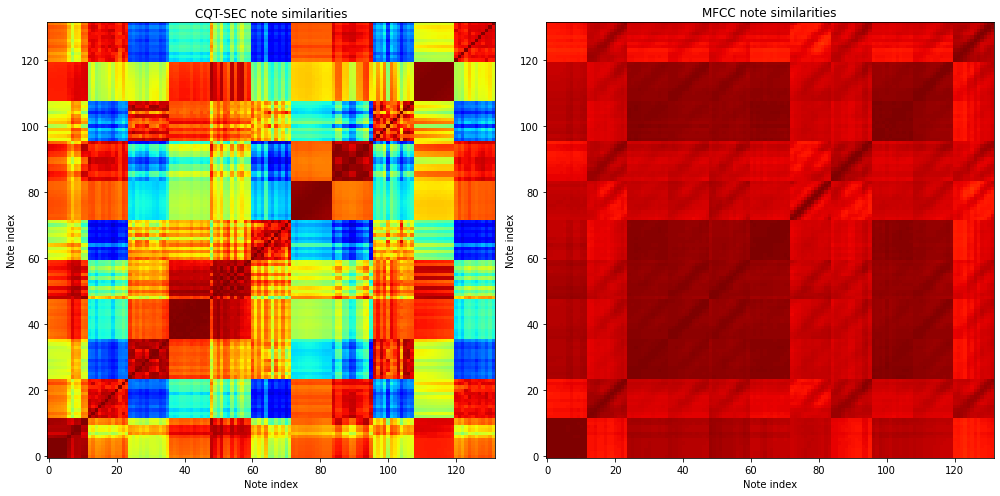

In [12]:
# Initialize the note similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_similarities = np.zeros((number_files, number_files))
mfcc_similarities = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the note similarity between the CQT-SECs and between the MFCCs
        cqtsec_similarities[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_similarities[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Display the note similarity matrices for the CQT-SECs and the MFCCs
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(cqtsec_similarities, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('CQT-SEC note similarities')
plt.xlabel('Note index')
plt.ylabel('Note index')
plt.subplot(1, 2, 2)
plt.imshow(mfcc_similarities, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('MFCC note similarities')
plt.xlabel('Note index')
plt.ylabel('Note index')
plt.tight_layout()
plt.show()

### 02.4. Compare the instrument similarities for the CQT-SECs and the MFCCs

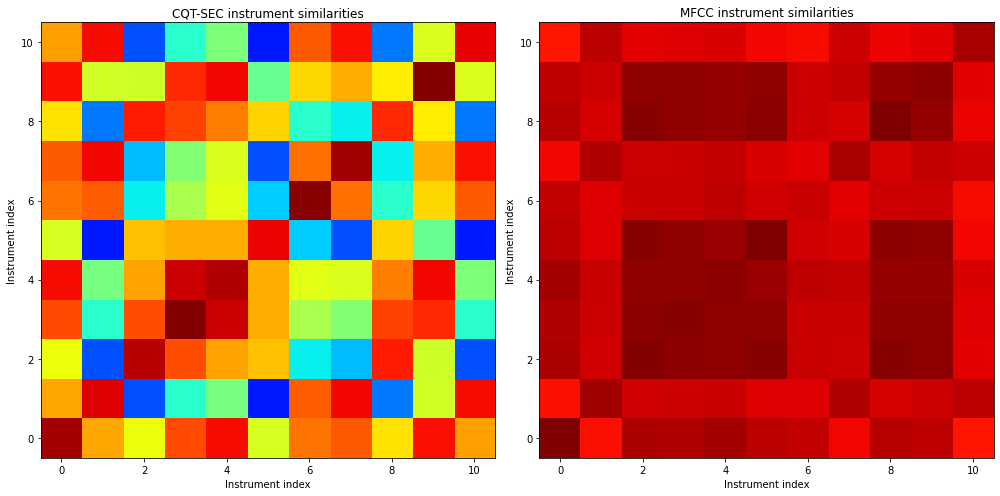

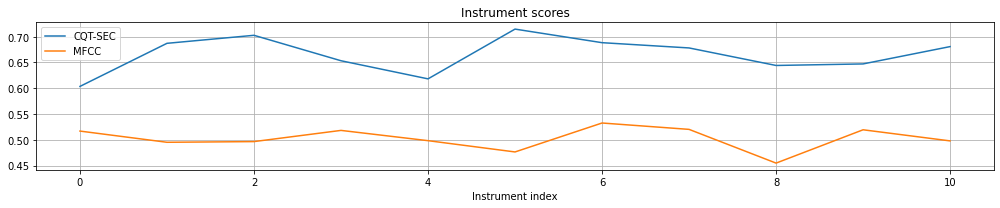

In [11]:
# Initialize the instrument similarity matrices and the final score vectors
number_instruments = 11
cqtsec_similarities2 = np.zeros((number_instruments, number_instruments))
mfcc_similarities2 = np.zeros((number_instruments, number_instruments))
cqtsec_scores2 = np.zeros(number_instruments)
mfcc_scores2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instruments
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_similarities2[i, j] = np.mean(cqtsec_similarities[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_similarities2[i, j] = np.mean(mfcc_similarities[i*12:(i+1)*12, j*12:(j+1)*12])

# Display the instrument similarity matrices
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(cqtsec_similarities2, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('CQT-SEC instrument similarities')
plt.xlabel('Instrument index')
plt.ylabel('Instrument index')
plt.subplot(1, 2, 2)
plt.imshow(mfcc_similarities2, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('MFCC instrument similarities')
plt.xlabel('Instrument index')
plt.ylabel('Instrument index')
plt.tight_layout()
plt.show()

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_scores2[i] = (cqtsec_similarities2[i, i] \
    + 1-((np.sum(cqtsec_similarities2[i, :])-cqtsec_similarities2[i, i])/(number_instruments-1)))/2
    mfcc_scores2[i] = (cqtsec_similarities2[i, i] \
    + 1-((np.sum(mfcc_similarities2[i, :])-mfcc_similarities2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.figure(figsize=(14, 3))
plt.plot(cqtsec_scores2, label='CQT-SEC')
plt.plot(mfcc_scores2, label='MFCC')
plt.title('Instrument scores')
plt.xlabel('Instrument index')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### 02.5. Compare the instrument similarity scores for different versions of the CQT-SECs, and the MFCCs

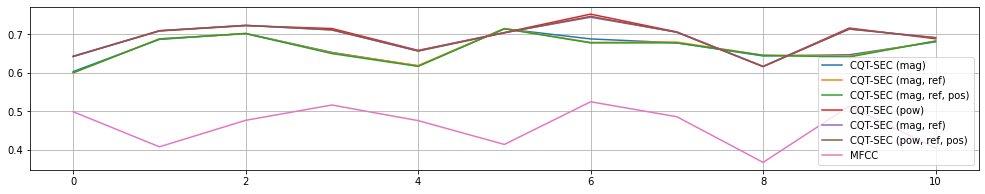

In [13]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 3))

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency, n_mfcc=20):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc

# Path to the folder
folder_path = r'nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)


# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution=12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT envelope and the CQT pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag)')


# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution=12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT envelope and the CQT pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    
# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref)')


# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution=12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT envelope and the CQT pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    
# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref, pos)')


# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution=12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT envelope and the CQT pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    
# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow)')


# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution=12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT envelope and the CQT pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict) 

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref)')


# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution=12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT envelope and the CQT pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow, ref, pos)')

plt.plot(mfcc_vector2, label='MFCC')
plt.grid()
plt.legend()
plt.show()